## Load the Dataset

##### Dataset Folder Structure
```plaintext
Dataset/
   ├── class1/
   │   ├── image1.jpg
   │   ├── image2.jpg
   └── class2/
       ├── image3.jpg
       ├── image4.jpg


In [1]:
import os
from sklearn import preprocessing # type: ignore

import pandas as pd # type: ignore
from PIL import Image # type: ignore
from torchvision.io import read_image # type: ignore
import torchvision.transforms as transforms # type: ignore
from torch.utils.data import DataLoader, Dataset # type: ignore

In [2]:
def load_dataset(root='D:/yogi/shoppin/ImageNet-Mini/augmented_images_200'):
  
  """
    Loads the dataset from the specified root directory and returns image file paths
    and their corresponding encoded labels.

  """
  img_paths= []
  labels= []

  for dir, folder, files in os.walk(root):

    for file in files:
      img_path= os.path.join(dir, file)
      img_paths.append(img_path)
      labels.append(os.path.basename(dir))


  label_encoder= preprocessing.LabelEncoder()
  img_ids= label_encoder.fit_transform(labels)

  return img_paths, img_ids

In [3]:
img_paths, img_ids= load_dataset()

## Split Dataset

In [4]:
from math import floor
import random

def split_data(img_paths, img_ids, ratio= 0.8):

    """
    Splits the dataset into training and testing subsets based on the specified ratio
    """

    # Combine data and labels into a list of tuples
    combined = list(zip(img_paths, img_ids))

    random.seed(42)

    # Shuffle the combined list
    random.shuffle(combined)

    # Split the shuffled combined list into two lists
    split_index = floor(len(combined) * ratio)

    train_combined  = combined[:split_index]
    test_combined   = combined[split_index:]

    # Unpack the combined tuples into separate paths and labels
    train_img_paths, train_img_ids   = zip(*train_combined)
    test_img_paths, test_img_ids     = zip(*test_combined)


    return train_img_paths, train_img_ids, test_img_paths, test_img_ids

In [5]:
train_img_paths, train_img_ids, test_img_paths, test_img_ids= split_data(img_paths, img_ids)

## Dataloader

In [6]:
def transform_image():

  '''
  transformation for training images
  '''
  
  transform= transforms.Compose([
      transforms.RandomHorizontalFlip(),
      transforms.RandomResizedCrop(224),
      transforms.ToTensor(),
      transforms.Lambda(lambda img: img.repeat(3, 1, 1) if img.shape[0] == 1 else img),
      transforms.Normalize(mean=0.5,  # Standard ImageNet normalization
      std=0.5)
  ])

  return transform

In [52]:
def transform_test_image():

  '''
  transformation for test images
  '''
  
  transform= transforms.Compose([
      transforms.Resize(224),
      # transforms.RandomResizedCrop(224),
      transforms.ToTensor(),
      transforms.Lambda(lambda img: img.repeat(3, 1, 1) if img.shape[0] == 1 else img),
      transforms.Normalize(mean=0.5,  # Standard ImageNet normalization
      std=0.5)
  ])

  return transform

In [11]:
class CustomImageDataset(Dataset):
    """
    A custom dataset class for loading and processing image data with associated labels
    """
    def __init__(self, image_paths, labels, transform=None, target_transform=None):
        self.image_paths = image_paths
        self.labels= labels
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [12]:
training_data   = CustomImageDataset(train_img_paths, train_img_ids, transform_image())
val_data        = CustomImageDataset(test_img_paths, test_img_ids, transform_test_image())

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
val_dataloader   = DataLoader(val_data, batch_size=64, shuffle=True)

## Model Configuration

In [7]:
import torch # type: ignore
from torchvision.models import resnet50, resnet34, resnet18 # type: ignore
import torch.nn as nn # type: ignore
from torch.optim import SGD, Adam # type: ignore
from torch.nn import CrossEntropyLoss # type: ignore

In [8]:
device= 'cuda' if torch.cuda.is_available() else 'cpu'

In [9]:
model= resnet34(weights= True)

c:\Users\ShivajiWankhede\anaconda3\envs\llm\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
in_features= 512
classes= 200

model.fc= nn.Sequential(nn.Linear(in_features, classes))

In [19]:
optimizer = Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
criteria  = CrossEntropyLoss()

## Training & Testing

In [18]:
def Train(model, train_dataloader, epoch):
  model.train()
  loss_running= 0
  total= 0
  correct= 0

  for idx, (inputs, labels) in enumerate(train_dataloader):
    inputs= inputs.to(device)
    labels= labels.to(device)
    outputs= model(inputs).to(device)

    loss = criteria(outputs, labels)
    loss_running += loss

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    _, predicted = outputs.max(1)

    total += labels.size(0)
    correct += predicted.eq(labels).sum().item()

    # print(f'Epoch {epoch + 1}: Batch idx: {idx}/{len(train_dataloader)} train accuracy: {correct/total} | train loss: {loss}')

  print(f'Epoch {epoch + 1}: train accuracy: {correct/total} | train loss: {loss_running/len(train_dataloader)}')

In [19]:
def Test(model, test_dataloader, epoch=0):
    model.eval()
    total= 0
    correct= 0
    predictions= []
    true_labels= []

    for input, labels in test_dataloader:
        input= input.to(device)
        labels= labels.to(device)
        outputs= model(input).to(device)

        _, predicted = outputs.max(1)
        predictions.extend(predicted)
        true_labels.extend(labels)

        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    print(f'Epoch: {epoch + 1} | test accuracy: {correct/total}')

In [20]:
epochs= 2
model= model.to(device)

for i in range(epochs):
    Train(model, train_dataloader, i)
    Test(model, val_dataloader, i)

Epoch 1: train accuracy: 0.9646935908059229 | train loss: 0.14787638187408447
Epoch: 1 | test accuracy: 0.9668587896253602
Epoch 2: train accuracy: 0.96602658788774 | train loss: 0.1417543739080429
Epoch: 2 | test accuracy: 0.9694524495677234


In [21]:
#save trained model
#torch.save(model.state_dict(), './checkpoints/model_200.pth')

## Enrollment

In [11]:
import json

# Convert tensors to lists for serialization
def tensor_to_list(obj):
    if isinstance(obj, torch.Tensor):
        return obj.tolist()  # Convert tensor to list
    raise TypeError(f"Object of type {obj.__class__.__name__} is not serializable")


def enroll_image(image_path, database= './database_cnn_200', model=None, weights= True, transformation= transform_test_image()):

  """
    Processes and enrolls an image by extracting its
    embeddings and saving them to a JSON file inside database
  """

  os.makedirs(database, exist_ok=True)

  image= Image.open(image_path).convert('RGB')
  transformed_image= transformation(image).unsqueeze(0).to(device)


  if model== None:
  
    if weights== True:
      model= resnet34(weights=True)
      model = nn.Sequential(*list(model.children())[:-1])
      model.load_state_dict(torch.load('checkpoints/feature_extractor_without_detector.pth'))
    
    else:
      model= resnet34(weights=True)
      model = nn.Sequential(*list(model.children())[:-1])

  model= model.to(device)
  model.eval()  
  embeddings= model(transformed_image).reshape(1,-1)
  
  name= os.path.basename(image_path).split('.JPEG')[0] + '.json'
  folder= os.path.basename(os.path.dirname(image_path))
  file_name= folder + '_@_' + name

  output_path= os.path.join(database, file_name)
  value= {image_path: embeddings}

  with open(output_path, 'w') as f:
      json.dump(value, f, default=tensor_to_list)

In [12]:
#load trained model
model.load_state_dict(torch.load('./checkpoints/model_200.pth'))

C:\Users\ShivajiWankhede\AppData\Local\Temp\ipykernel_17104\2678201918.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./checkpoints/mo

<All keys matched successfully>

In [13]:
backbone_model = nn.Sequential(*list(model.children())[:-1])

In [34]:
#Enrolling all training images to database

for i, path in enumerate(train_img_paths):
    enroll_image( path, model= backbone_model)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

## Evaluation

Note:

To evaluate the model's performance please follow following steps:

1. Load and split the dataset mentioned in the initial sections
2. Enroll the 'train_img_paths' to the database by following enrollment section
3. Now execute 'calculate_precision' or 'calculate_recall' on test_img_paths to get the results

In [14]:
import requests # type: ignore
from io import BytesIO

from sklearn.metrics.pairwise import cosine_similarity # type: ignore
import matplotlib.pyplot as plt # type: ignore
import numpy as np # type: ignore

In [15]:
def download_image(url):
    response = requests.get(url)
    response.raise_for_status()  # Raise an exception for HTTP errors
    
    # Open the image from the response content
    img = Image.open(BytesIO(response.content))

    return img

In [70]:
def precision_at_k(image_path=None, url= None, model= None, database_folder='./database_cnn_200', k=1, transformation= transform_test_image()):
    
    """
    Computes Precision@K for an input image or URL against a database of embeddings

    Args:
        image_path (str, optional): Path to the probe image for comparison. 
                                    Required if `url` is not provided. Default is None.
        url (str, optional): URL of the probe image for comparison. Used if `image_path` is not provided. Default is None.
        model (torch.nn.Module, optional): Pre-trained feature extraction model. If None, a ResNet34 model with pre-trained weights is used. 
                                           Default is None.
        database_folder (str, optional): Path to the folder containing JSON files with embeddings. Default is './database_cnn_200'.
        k (int, optional): The number of top results to consider for Precision@K. Default is 1.
        transformation (callable, optional): Transformation function applied to the probe image before feature extraction. 
                                             Default is `transform_image()`.

    Returns:
        float: The precision score for the top `k` results, calculated as:
               Precision@K = (Number of true positives in top `k` results) / `k`
               
    """

    device= 'cuda' if torch.cuda.is_available() else 'cpu'

    probe_label= os.path.basename(os.path.dirname(image_path))

    if url== None:
        image= Image.open(image_path)
        transformed_image= transformation(image).unsqueeze(0).to(device)
    else:
        image= download_image(url)
        transformed_image= transformation(image).unsqueeze(0).to(device)

    if model== None:
        model= resnet34(weights=True)
        model.load_state_dict(torch.load('checkpoints/model_200.pth'))
        model = nn.Sequential(*list(model.children())[:-1])

    model= model.to(device)
    model.eval()

    with torch.no_grad():
        query_embedding= model(transformed_image).reshape(1,-1).cpu()


    # Load all database embeddings into memory
    database_embeddings = []
    labels = []

    for json_file in os.listdir(database_folder):
        if json_file.endswith('.json'):
            json_path = os.path.join(database_folder, json_file)
            
            with open(json_path, 'r') as file:
                database = json.load(file)
            
            for path, emb in database.items():
                folder = os.path.basename(os.path.dirname(path))
                labels.append(folder)
                database_embeddings.append(torch.tensor(emb).numpy())

    # Convert embeddings and query to NumPy arrays
    database_embeddings = np.vstack(database_embeddings)
    query_embedding = query_embedding.numpy()

    # Compute cosine similarity in a batch
    similarities = cosine_similarity(database_embeddings, query_embedding)

    # Combine labels and similarities, then get top-k
    labeled_scores = list(zip(labels, similarities[:, 0]))
    top_k_scores = sorted(labeled_scores, key=lambda x: x[1], reverse=True)[:k]

    # Calculate Precision@k
    true_positive = sum(1 for label, _ in top_k_scores if label == probe_label)
    precision = true_positive / k

    print(f'Precision@k={k}: {precision}')


    return precision    

In [74]:
def recall_at_k(image_path=None, url= None, model= None, database_folder='./database_cnn_200', k=1, transformation= transform_test_image()):
    
    """
    Computes Recall@K for an input image or URL against a database of embeddings.

    Args:
        image_path (str, optional): Path to the probe image for comparison. 
                                    Required if `url` is not provided. Default is None.
        url (str, optional): URL of the probe image for comparison. Used if `image_path` is not provided. Default is None.
        model (torch.nn.Module, optional): Pre-trained feature extraction model. If None, a ResNet34 model with pre-trained weights is used. 
                                           Default is None.
        database_folder (str, optional): Path to the folder containing JSON files with embeddings. Default is './database_cnn_200'.
        k (int, optional): The number of top results to consider for Recall@K. Default is 1.
        transformation (callable, optional): Transformation function applied to the probe image before feature extraction. 
                                             Default is `transform_image()`.

    Returns:
        float: The recall score for the top `k` results, calculated as:
               Recall@K = (Number of true positives in top `k` results) / (Total number of relevant items in the database)

    """           

    device= 'cuda' if torch.cuda.is_available() else 'cpu'
         
    probe_label= os.path.basename(os.path.dirname(image_path))

    if url== None:
        image= Image.open(image_path)
        transformed_image= transformation(image).unsqueeze(0).to(device)
    else:
        image= download_image(url)
        transformed_image= transformation(image).unsqueeze(0).to(device)

    if model== None:
        model= resnet34(weights=True)
        model.load_state_dict(torch.load('checkpoints/model_200.pth'))
        model = nn.Sequential(*list(model.children())[:-1])

    model= model.to(device)
    model.eval()

    with torch.no_grad():
        query_embedding= model(transformed_image).reshape(1,-1).cpu()


    # Load all database embeddings into memory
    database_embeddings = []
    labels = []
    True_positive= 0
    Total_relevant_items= 0


    for json_file in os.listdir(database_folder):
        if json_file.endswith('.json'):
            json_path = os.path.join(database_folder, json_file)
            
            with open(json_path, 'r') as file:
                database = json.load(file)
            
            for path, emb in database.items():
                folder = os.path.basename(os.path.dirname(path))

                if folder == probe_label:
                    Total_relevant_items += 1

                labels.append(folder)
                database_embeddings.append(torch.tensor(emb).numpy())

    # Convert embeddings and query to NumPy arrays
    database_embeddings = np.vstack(database_embeddings)
    query_embedding = query_embedding.numpy()

    # Compute cosine similarity in a batch
    similarities = cosine_similarity(database_embeddings, query_embedding)

    # Combine labels and similarities, then get top-k
    labeled_scores = list(zip(labels, similarities[:, 0]))
    sorted_scores = sorted(labeled_scores, key=lambda x: x[1], reverse=True)[:k]


    for i in range(k):
        if sorted_scores[i][0] == probe_label:
            True_positive += 1
    

    recall= True_positive/Total_relevant_items
    print(f'recall@k={k}: {recall}')

    return recall    

In [77]:
# average precision of the model

def calculate_precision(test_image_paths, model, k=10):
    '''
    This function iterates over a list of test image paths, computes the precision at `k` 
    for each image using the `precision_at_k` function, and then calculates the average 
    precision across all test images
    '''

    precision_sum= 0
    count= 0

    for img_path in test_image_paths:
        value= precision_at_k(img_path, model=model, k=k)
        precision_sum += value
        count += 1

    print(f'average precision @ k={k}: {precision_sum/count}')


calculate_precision(test_img_paths[:100], backbone_model)

Precision@k=10: 1.0
Precision@k=10: 1.0
Precision@k=10: 1.0
Precision@k=10: 1.0
Precision@k=10: 1.0
Precision@k=10: 1.0
Precision@k=10: 1.0
Precision@k=10: 1.0
Precision@k=10: 1.0
Precision@k=10: 1.0
Precision@k=10: 1.0
Precision@k=10: 1.0
Precision@k=10: 1.0
Precision@k=10: 1.0
Precision@k=10: 1.0
Precision@k=10: 1.0
Precision@k=10: 1.0
Precision@k=10: 1.0
Precision@k=10: 1.0
Precision@k=10: 1.0
Precision@k=10: 1.0
Precision@k=10: 1.0
Precision@k=10: 1.0
Precision@k=10: 1.0
Precision@k=10: 1.0
Precision@k=10: 1.0
Precision@k=10: 1.0
Precision@k=10: 1.0
Precision@k=10: 1.0
Precision@k=10: 1.0
Precision@k=10: 1.0
Precision@k=10: 1.0
Precision@k=10: 1.0
Precision@k=10: 1.0
Precision@k=10: 1.0
Precision@k=10: 1.0
Precision@k=10: 1.0
Precision@k=10: 1.0
Precision@k=10: 1.0
Precision@k=10: 1.0
Precision@k=10: 1.0
Precision@k=10: 1.0
Precision@k=10: 1.0
Precision@k=10: 1.0
Precision@k=10: 1.0
Precision@k=10: 1.0
Precision@k=10: 1.0
Precision@k=10: 1.0
Precision@k=10: 1.0
Precision@k=10: 1.0


In [78]:
# average precision of the model

def calculate_recall(test_image_paths, model, k=50):
    '''
    This function iterates over a list of test image paths, computes the recall at `k` 
    for each image using the `recall_at_k` function, and then calculates the average 
    recall across all test images
    '''

    recall_sum= 0
    count= 0
    

    for img_path in test_image_paths:
        value= recall_at_k(img_path, model=model, k=k)
        recall_sum += value
        count += 1

    print(f'average recall @ k={k}: {recall_sum/count}')


calculate_recall(test_img_paths[:100], backbone_model)

recall@k=50: 0.45045045045045046
recall@k=50: 0.24875621890547264
recall@k=50: 0.4032258064516129
recall@k=50: 0.31446540880503143
recall@k=50: 0.31645569620253167
recall@k=50: 0.31446540880503143
recall@k=50: 0.25380710659898476
recall@k=50: 0.3858267716535433
recall@k=50: 0.2403846153846154
recall@k=50: 0.3137254901960784
recall@k=50: 0.3184713375796178
recall@k=50: 0.4132231404958678
recall@k=50: 0.4032258064516129
recall@k=50: 0.25380710659898476
recall@k=50: 0.43478260869565216
recall@k=50: 0.32051282051282054
recall@k=50: 0.3181818181818182
recall@k=50: 0.3787878787878788
recall@k=50: 0.4166666666666667
recall@k=50: 0.11037527593818984
recall@k=50: 0.46296296296296297
recall@k=50: 0.3067484662576687
recall@k=50: 0.24271844660194175
recall@k=50: 0.2631578947368421
recall@k=50: 0.4032258064516129
recall@k=50: 0.3067484662576687
recall@k=50: 0.2358490566037736
recall@k=50: 0.46226415094339623
recall@k=50: 0.390625
recall@k=50: 0.32051282051282054
recall@k=50: 0.32679738562091504
rec

## Probe

In [65]:
def top_k_matches(image_path=None, url= None, model= None, database_folder='./database_cnn_200', k=1, transformation= transform_test_image()):

    """
    Retrieves & displays the top-k matching images from a database for a given input image or URL
    """

    device= 'cuda' if torch.cuda.is_available() else 'cpu'

    if url== None:
        image= Image.open(image_path)
        transformed_image= transformation(image).unsqueeze(0).to(device)
    else:
        image= download_image(url)
        transformed_image= transformation(image).unsqueeze(0).to(device)

    if model== None:
        model= resnet34(weights=True)
        model = nn.Sequential(*list(model.children())[:-1])
        model.load_state_dict(torch.load('checkpoints/feature_extractor_without_detector.pth'))

    model= model.to(device)
    model.eval()

    with torch.no_grad():
        query_embedding= model(transformed_image).reshape(1,-1).cpu()


    # Load all database embeddings into memory
    database_embeddings = []
    paths = []

    for json_file in os.listdir(database_folder):
        if json_file.endswith('.json'):
            json_path = os.path.join(database_folder, json_file)
            
            with open(json_path, 'r') as file:
                database = json.load(file)
            
            for path, emb in database.items():
                # folder = os.path.basename(os.path.dirname(path))
                paths.append(path)
                database_embeddings.append(torch.tensor(emb).numpy())

    # Convert embeddings and query to NumPy arrays
    database_embeddings = np.vstack(database_embeddings)
    query_embedding = query_embedding.numpy()

    # Compute cosine similarity in a batch
    similarities = cosine_similarity(database_embeddings, query_embedding)

    # Combine labels and similarities, then get top-k
    labeled_scores = list(zip(paths, similarities[:, 0]))
    top_k_scores = sorted(labeled_scores, key=lambda x: x[1], reverse=True)[:k]


    # Define the grid size (rows and columns)
    rows = k
    cols = 2  # Adjust rows and cols based on `k`


    # Plot the images
    fig, axes = plt.subplots(rows, cols, figsize=(10, 6))

    # If axes is a single object (when k=1), convert it to a 2D array for consistency
    if rows == 1:
        axes = np.array([axes])  # Convert to 2D array with one row

    # Loop through each row to plot input image and the corresponding match
    for i in range(rows):
        # Plot the input image in the first column
        axes[i, 0].imshow(image)
        axes[i, 0].axis('off')
        axes[i, 0].set_title('Input Image')

        # Plot the corresponding top match in the second column
        if i < k:
            retrieved_image = Image.open(top_k_scores[i][0])
            axes[i, 1].imshow(retrieved_image)
            axes[i, 1].axis("off")
            axes[i, 1].set_title(f"Match {i + 1}")
        else:
            axes[i, 1].axis("off")  # Turn off any extra axes

    plt.tight_layout()
    plt.show()
    

    return top_k_scores

('D:/yogi/shoppin/ImageNet-Mini/augmented_images_200\\n02094258\\ILSVRC2012_val_00038911_aug_48.JPEG', np.float32(0.95590764))


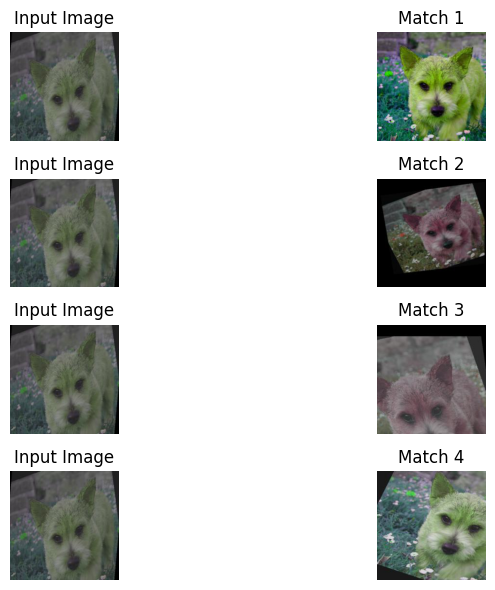

In [66]:
# retrieves top k matches from the database for a given input

score= top_k_matches(image_path=test_img_paths[2], model= backbone_model, k=4)

pehle scores: [('D:/yogi/shoppin/ImageNet-Mini/augmented_images\\n02484975\\ILSVRC2012_val_00000013_aug_0.JPEG', array([[0.5958537]], dtype=float32)), ('D:/yogi/shoppin/ImageNet-Mini/augmented_images\\n02484975\\ILSVRC2012_val_00000013_aug_1.JPEG', array([[0.5444288]], dtype=float32)), ('D:/yogi/shoppin/ImageNet-Mini/augmented_images\\n02484975\\ILSVRC2012_val_00000013_aug_3.JPEG', array([[0.57408845]], dtype=float32)), ('D:/yogi/shoppin/ImageNet-Mini/augmented_images\\n02484975\\ILSVRC2012_val_00000013_aug_4.JPEG', array([[0.54468524]], dtype=float32)), ('D:/yogi/shoppin/ImageNet-Mini/augmented_images\\n01729977\\ILSVRC2012_val_00000029_aug_0.JPEG', array([[0.61482155]], dtype=float32)), ('D:/yogi/shoppin/ImageNet-Mini/augmented_images\\n01729977\\ILSVRC2012_val_00000029_aug_1.JPEG', array([[0.59613836]], dtype=float32)), ('D:/yogi/shoppin/ImageNet-Mini/augmented_images\\n01729977\\ILSVRC2012_val_00000029_aug_2.JPEG', array([[0.6416754]], dtype=float32)), ('D:/yogi/shoppin/ImageNet-Mi

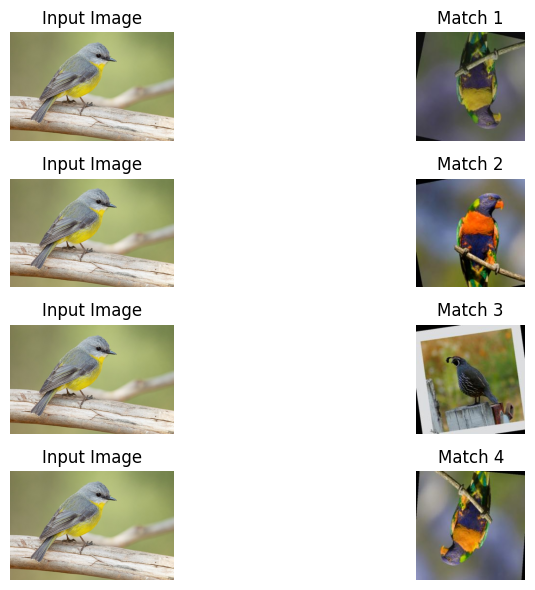

In [37]:
#test example with image url

image_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/4/45/Eopsaltria_australis_-_Mogo_Campground.jpg/640px-Eopsaltria_australis_-_Mogo_Campground.jpg"
score= top_k_matches(url=image_url, model= backbone_model, k=4)